# EDA.ipynb

This notebook demonstrates an end-to-end Exploratory Data Analysis (EDA) workflow for a COCO-format image dataset. 

In [7]:
#############################
# 0. (Optional) Install Packages Directly Here
#############################
# If needed in a Jupyter environment:
# %pip install pycocotools opencv-python-headless s3fs matplotlib seaborn

#############################
# 1. Imports & Environment Checks
#############################

# (Optional) for reading from S3 directly
import s3fs


import sys
print("Python executable:", sys.executable)
print("Python version:", sys.version)

import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pycocotools.coco import COCO

%matplotlib inline
sns.set_style('whitegrid')

Python executable: /opt/conda/bin/python
Python version: 3.11.11 | packaged by conda-forge | (main, Dec  5 2024, 14:17:24) [GCC 13.3.0]


In [8]:
from pycocotools.coco import COCO

# Initialize with a local annotation file
coco = COCO('lemon-dataset/annotations/instances_default.json')

# List all image IDs
img_ids = coco.getImgIds()

# Load metadata for a specific image
img_info = coco.loadImgs(img_ids[0])[0]

# Load annotation IDs for that image
ann_ids = coco.getAnnIds(imgIds=img_info['id'])
annotations = coco.loadAnns(ann_ids)

loading annotations into memory...
Done (t=1.19s)
creating index...
index created!


In [9]:
#############################
# 3. Convert Annotations to DataFrames
#############################
df_images = pd.DataFrame(coco.dataset['images'])
df_annotations = pd.DataFrame(coco.dataset['annotations'])
df_categories = pd.DataFrame(coco.dataset['categories'])

print("Number of images:", len(df_images))
print("Number of annotations:", len(df_annotations))
print("Number of categories:", len(df_categories))

Number of images: 2690
Number of annotations: 33753
Number of categories: 9



Category counts:
 name
blemish               19678
illness               10327
pedicel                1311
gangrene                929
artifact                576
dark_style_remains      572
mould                   352
image_quality             6
condition                 2
Name: count, dtype: int64


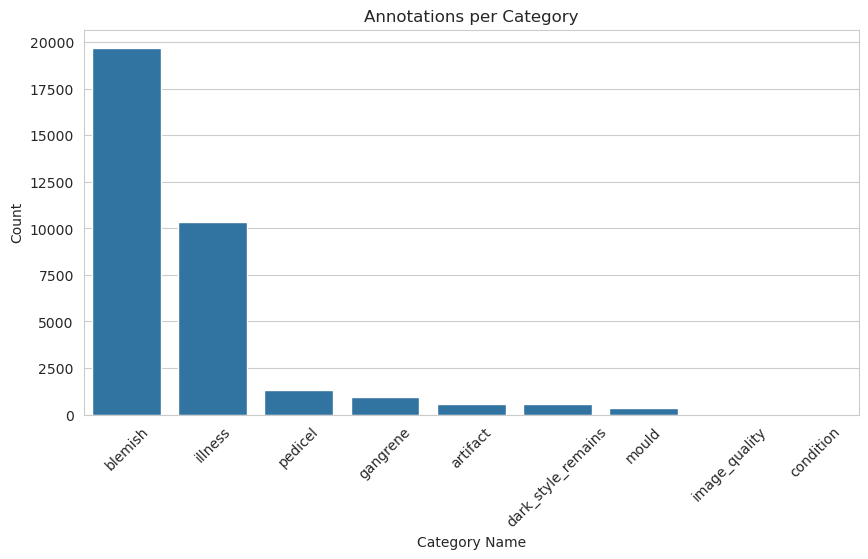

In [10]:
#############################
# 4. Category Distribution
#############################
# Merge annotation and category info for readable category names
df_anno_with_cat = df_annotations.merge(
    df_categories,
    left_on='category_id',
    right_on='id',
    suffixes=('_anno', '_cat')
)

cat_counts = df_anno_with_cat['name'].value_counts()
print("\nCategory counts:\n", cat_counts)

plt.figure(figsize=(10,5))
sns.barplot(x=cat_counts.index, y=cat_counts.values)
plt.title("Annotations per Category")
plt.xlabel("Category Name")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


Bounding Box Stats:
          bbox_width   bbox_height      bbox_area
count  33753.000000  33753.000000   33753.000000
mean      25.416574     25.142335    2528.362970
std       45.402822     46.251245   14337.656522
min        1.500000      1.500000       2.550000
25%        6.106307      5.904431      37.960000
50%       12.023193     11.400000     140.075290
75%       25.974075     24.559104     608.600018
max      582.370558    569.890664  247588.495891


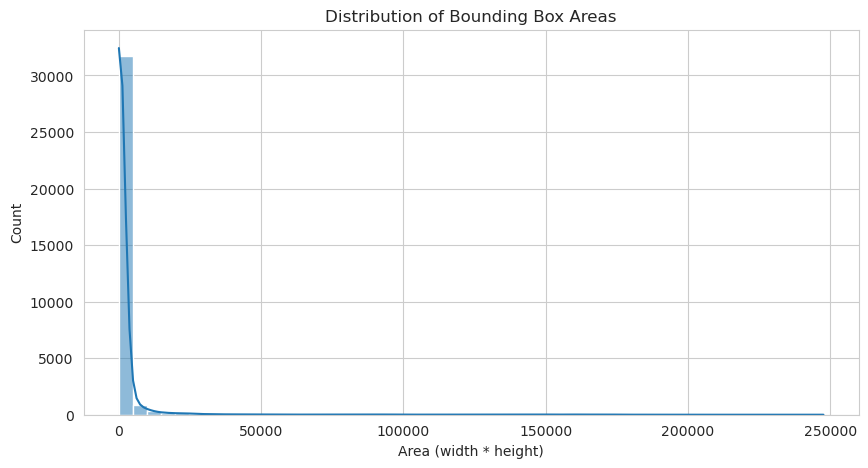

In [11]:
#############################
# 5. Bounding Box Analysis
#############################
# COCO: bbox = [x, y, width, height]
df_annotations['bbox_width'] = df_annotations['bbox'].apply(lambda x: x[2])
df_annotations['bbox_height'] = df_annotations['bbox'].apply(lambda x: x[3])
df_annotations['bbox_area'] = df_annotations['bbox_width'] * df_annotations['bbox_height']

print("\nBounding Box Stats:\n", df_annotations[['bbox_width','bbox_height','bbox_area']].describe())

plt.figure(figsize=(10,5))
sns.histplot(df_annotations['bbox_area'], bins=50, kde=True)
plt.title("Distribution of Bounding Box Areas")
plt.xlabel("Area (width * height)")
plt.show()


Objects per Image Stats:
 count    2690.000000
mean       12.547584
std        13.070943
min         1.000000
25%         3.000000
50%         8.000000
75%        17.000000
max       113.000000
Name: id, dtype: float64


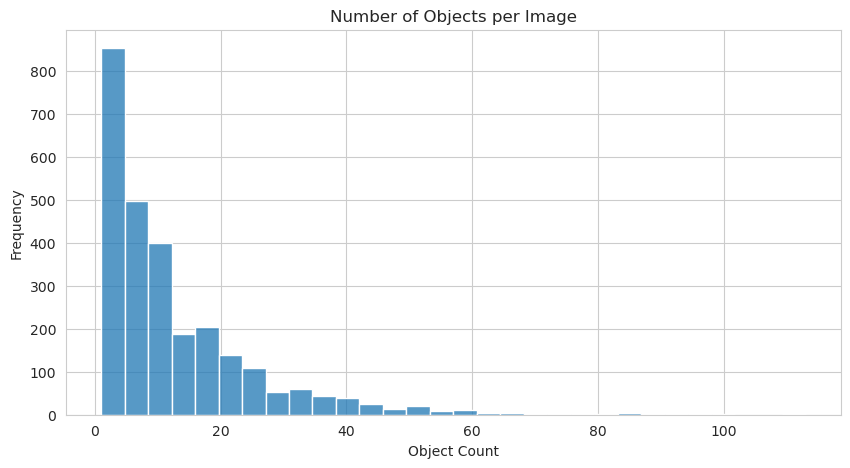

In [12]:
#############################
# 6. Objects per Image
#############################
objects_per_image = df_annotations.groupby('image_id')['id'].count()
print("\nObjects per Image Stats:\n", objects_per_image.describe())

plt.figure(figsize=(10,5))
sns.histplot(objects_per_image, bins=30, kde=False)
plt.title("Number of Objects per Image")
plt.xlabel("Object Count")
plt.ylabel("Frequency")
plt.show()


Image Dimension Stats:
         width  height
count  2690.0  2690.0
mean   1056.0  1056.0
std       0.0     0.0
min    1056.0  1056.0
25%    1056.0  1056.0
50%    1056.0  1056.0
75%    1056.0  1056.0
max    1056.0  1056.0


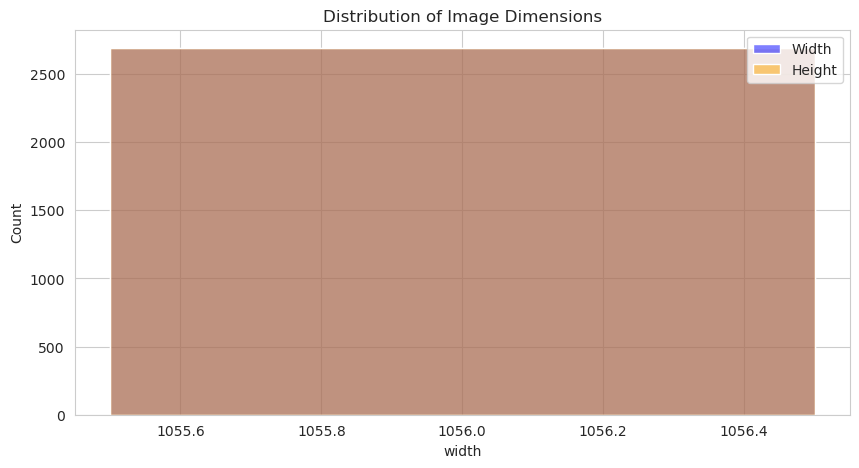

In [13]:
#############################
# 7. Image Dimensions (If Available)
#############################
if 'width' in df_images.columns and 'height' in df_images.columns:
    print("\nImage Dimension Stats:\n", df_images[['width','height']].describe())
    
    plt.figure(figsize=(10,5))
    sns.histplot(df_images['width'], color='blue', label='Width', kde=True)
    sns.histplot(df_images['height'], color='orange', label='Height', kde=True)
    plt.title("Distribution of Image Dimensions")
    plt.legend()
    plt.show()
else:
    print("\nNo width/height columns found in df_images. Skipping dimension analysis.")

In [14]:
#############################
# 8. (Optional) Visualize Sample Annotations
#############################
# This requires local images + cv2 (or PIL).
# If images are on S3, download them or mount them first.

def visualize_coco_annotation(coco_obj, image_id, image_dir='images'):
    """
    Displays an image with bounding boxes drawn for each annotation.
    Expects local images in `image_dir` matching `file_name`.
    """
    # Get image metadata
    img_info = coco_obj.loadImgs([image_id])[0]
    img_path = os.path.join(image_dir, img_info['file_name'])
    
    # Load the image via cv2
    img = cv2.imread(img_path)
    if img is None:
        print(f"Could not read image: {img_path}")
        return
    
    # Get annotation IDs for this image
    ann_ids = coco_obj.getAnnIds(imgIds=[image_id])
    anns = coco_obj.loadAnns(ann_ids)
    
    for ann in anns:
        x, y, w, h = ann['bbox']
        category_id = ann['category_id']
        
        # Example: green box
        color = (0, 255, 0)
        thickness = 2
        cv2.rectangle(img, (int(x), int(y)), (int(x+w), int(y+h)), color, thickness)
        
        # Optional text label with category name
        cat_name = coco_obj.loadCats([category_id])[0]['name']
        cv2.putText(img, cat_name, (int(x), int(y)-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    
    # Convert BGR -> RGB for display in matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8,6))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"Image ID: {image_id}")
    plt.show()

# Example usage:
# sample_image_id = df_images.sample(1)['id'].values[0]
# visualize_coco_annotation(coco, sample_image_id, image_dir='path/to/local/images')

print("\nEDA complete!")


EDA complete!
